In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Imports
import numpy as np
import sys
from os import makedirs
from os.path import join
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs, make_circles

rng_seed = 399
np.random.seed(rng_seed)

sys.path.append("..")

from gudhi import plot_persistence_diagram
from gudhi.rips_complex import RipsComplex
from vis_utils import configure_plotting_for_thesis

configure_plotting_for_thesis()

Plots configured for thesis!


<IPython.core.display.Javascript object>

In [3]:
# Constants
output_dir = "output_plots"
makedirs(output_dir, exist_ok=True)
save_plots_to_file = True

<IPython.core.display.Javascript object>

## Persistence diagram example

In [4]:
# Create data
pd_data = np.row_stack(
    [
        make_blobs(
            n_samples=10, cluster_std=0.75, center_box=(2, 2), random_state=rng_seed
        )[0],
        make_blobs(
            n_samples=10,
            cluster_std=0.75,
            center_box=(-2, -2),
            random_state=rng_seed + 1,
        )[0],
    ]
)
alpha_levels = [0.2, 1.5, 4.5]

<IPython.core.display.Javascript object>

usetex mode requires dvipng.


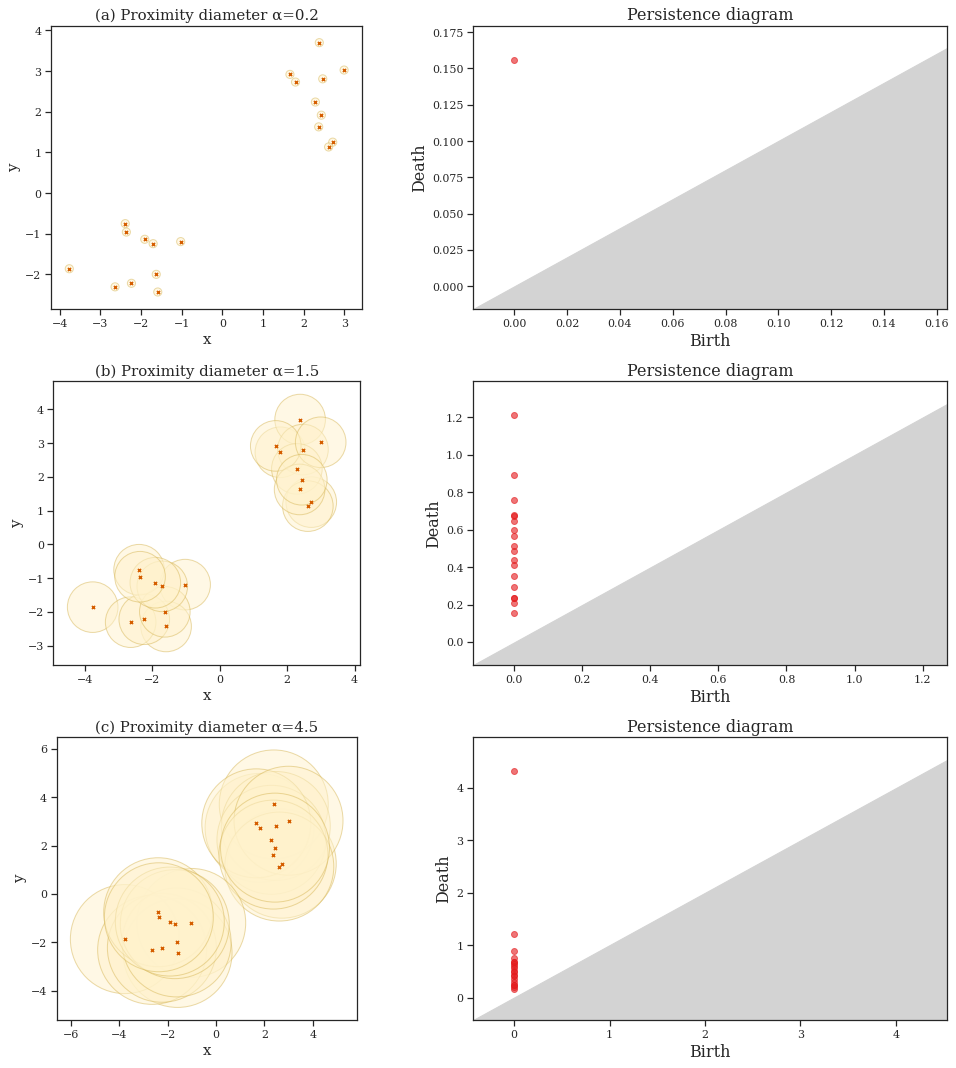

<IPython.core.display.Javascript object>

In [5]:
# Create persistence diagram data
rips_complex = RipsComplex(pd_data)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
barcodes = simplex_tree.persistence()

# Plot example
plot_chars = "abc"
font_params = {"fontdict": {"fontsize": 15}}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7 * 2, 5 * 3))
for alpha_level, plot_char, (ax1, ax2) in zip(alpha_levels, plot_chars, axes):

    # Plot data points
    ax1.set_aspect("equal", adjustable="box")
    for i in range(len(pd_data)):
        ax1.add_patch(
            plt.Circle(
                xy=tuple(pd_data[i]),
                radius=alpha_level / 2,
                alpha=0.5,
                facecolor="#fff2cc",
                edgecolor="#d6b656",
            )
        )
    ax1.scatter(pd_data[:, 0], pd_data[:, 1], s=10, c="r", marker="x", zorder=100)
    ax1.set_title(f"({plot_char}) Proximity diameter α={alpha_level}", **font_params)
    ax1.set_xlabel("x", **font_params)
    ax1.set_ylabel("y", **font_params)

    # Plot PD
    plot_persistence_diagram(
        [
            (dim, (birth, death))
            for dim, (birth, death) in barcodes
            if death <= alpha_level
        ],
        axes=ax2,
    )

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(join(output_dir, "persistence-diagram-example.pdf"), backend="pgf")
else:
    plt.show()